In [63]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model

def readDF(EXPID, base_path="data", NODE="baati"):
    DATA_PATH = glob.glob(os.path.join(base_path, EXPID, f"VM_runtime_app_*.csv"))[0]
    RESOURCES_PATH = glob.glob(os.path.join(base_path, EXPID, f"resources/metric_node_*_cpu.csv"))[0]
    SKIPROWS=28
    
    df = pd.read_csv(DATA_PATH, skiprows=SKIPROWS, parse_dates=True)
    res = pd.read_csv(RESOURCES_PATH)
    df["datetime"] = pd.to_datetime(df["time_h"])
    return df, res

def splitDF(df, ai_name="ai_1"):
    ais = df["ai_name"].unique()
    ts = [df.loc[df["ai_name"] == ai, "datetime"].min() for ai in ais]
    ts.append(df["datetime"].max())
    ts.sort()
    if ai_name is not None:
        df = df[df["ai_name"] == ai_name]
    return [df[(ta <= df["datetime"]) & (df["datetime"] <= tb)] for (ta, tb) in zip(ts[:-1], ts[1:])]

def getMetrics(dfs, metric_name="app_latency"):
    metric = np.array([df2[metric_name].mean() for df2 in dfs])
    stddev = np.array([df2[metric_name].std() for df2 in dfs])
    return metric, stddev

def plotPerf(df, expid, metric_name="app_latency"):
    dfs = splitDF(df)
    fig, ax = plt.subplots()
    metric, metric_stddev = getMetrics(dfs)
    ax.errorbar(range(1, len(metric)+1), metric, yerr=metric_stddev)
    ax.set_ylabel(metric_name)
    ax.set_title(expid)
    plt.show()
    
def plotRegressionLine(ax, x, y, yerr, b, expid=None, metric_name="app_latency"): 
    x = np.array(x)
    ax.errorbar(x, y,yerr, color = "m", fmt="o") 
    #plt.scatter(x, y, color = "m", yerr=yerr, 
    #           marker = "o", s = 30) 
    y_pred = b[0] + b[1]*x 
    ax.plot(x, y_pred, color = "g") 
    #plt.show()
    
def getXs(ys):
    return list(range(1, len(ys)+1))

def fitRegression(ys):
    xs2 = [[i] for i in getXs(ys)]
    reg = linear_model.LinearRegression()
    reg.fit(xs2, ys)
    return np.array([reg.intercept_, reg.coef_[0]])

    
def analizeData(expid, ax, base_path="data", metric_name="app_latency", rescale=False, silent=False):
    print(expid)
    df, res = readDF(expid, base_path)
    dfs = splitDF(df)
    ys, yerr = getMetrics(dfs, metric_name)
    if rescale:
        factor = ys[0]
        ys /= factor
        yerr /= factor
    coef = fitRegression(ys)
    if not silent:
        plotRegressionLine(ax, getXs(ys), ys, yerr, coef, expid, metric_name)
        #print (f"Coef: {coef}")
        #df[metric_name].plot()
        #plt.show()
        #res["value"].plot()
    return coef
    
expid = "61redis"
#analizeData(expid, plt)

redis_1
redis_wrk_1
redis_hadoop_1
redis_linpack_1
wrk_redis_1
wrk_1
wrk_hadoop_1
wrk_linpack_1
hadoop_redis_1
hadoop_wrk_1
hadoop_1
hadoop_linpack_1
linpack_redis_1
linpack_wrk_1
linpack_hadoop_1
linpack_1


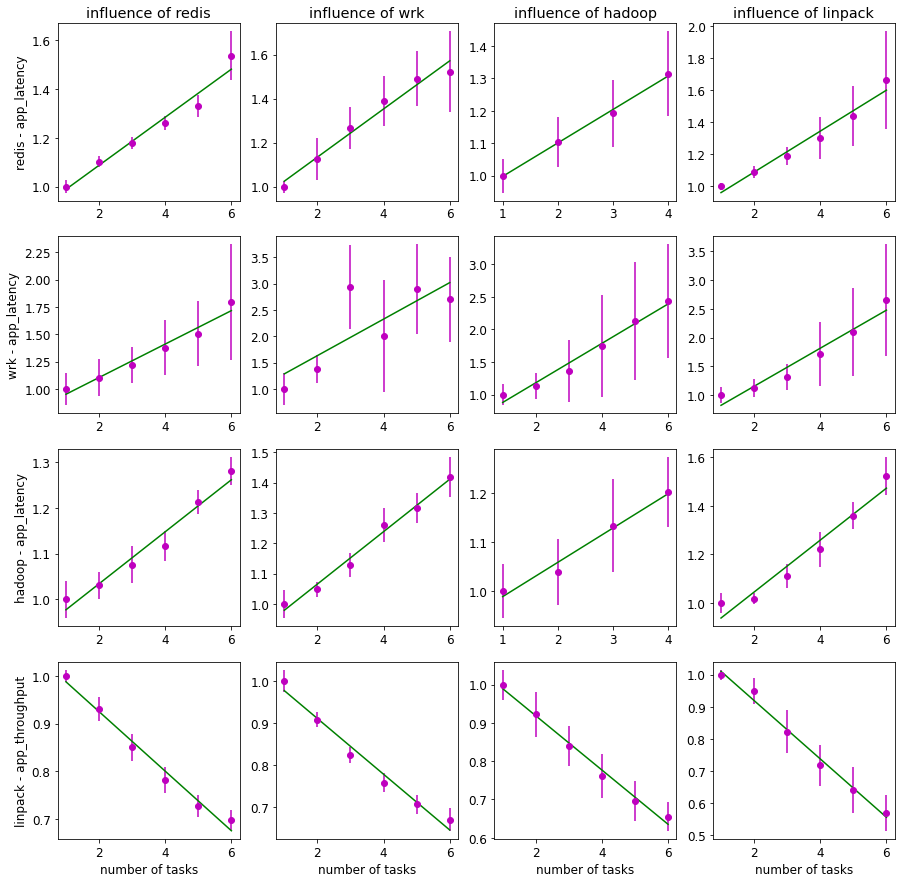

[[0.09850463 0.10939086 0.10299651 0.12770357]
 [0.15296261 0.34636941 0.30279389 0.33084764]
 [0.05699619 0.08645344 0.07038867 0.10692214]
 [0.06254286 0.06645851 0.0709298  0.09099933]]


In [64]:
"""
# TODO print cost function
"""
def formatLegend(ax, expid, metric_name, i, j, n):
    expid_parts = expid.split("_")
    xtask = expid_parts[0]
    if len(expid_parts) <= 2:
        ytask = expid_parts[0]
    else:
        ytask = expid_parts[1]
    
    if j == n-1:
        ax.set_xlabel('number of tasks') 
    if not j:
        ax.set_title(f"influence of {ytask}")
    if not i:
        ax.set_ylabel(f"{xtask} - {metric_name}") 

tasks = ["redis", "wrk", "hadoop", "linpack"]
#tasks = ["redis", "wrk"]
n = len(tasks)
expids = [f"{t1}_{t2}_1" if t1 != t2 else f"{t1}_1" for t1 in tasks for t2 in tasks]
#print(expids)
base_dir = "../results/all_limitless/baati"
rescale=True
silent=False

inference = []
fig, axes = plt.subplots(n, n, figsize=(15., 15.))
for i, expid in enumerate(expids):
    if expid.startswith("linpack"):
        metric = "app_throughput"
        sign = -1.
    else:
        metric ="app_latency"
        sign = 1.
    j, k = int(i / n), int(i % n)
    ax = axes[j, k]
    formatLegend(ax, expid, metric, k, j, n)
    coefs = analizeData(expid, ax, base_dir, metric, rescale=rescale, silent=silent)
    inference.append(coefs[1] * sign)
plt.show()
inference = np.array(inference)
inference.resize([n, n])
print(inference)

12.0


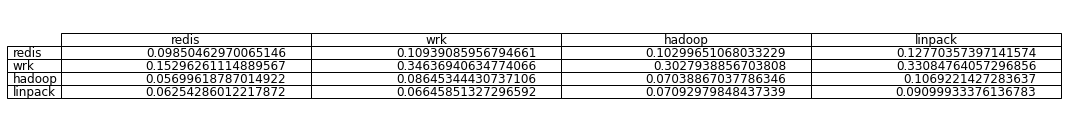

In [24]:
fig, ax = plt.subplots()
fig.patch.set_visible(False)
fig.set_size_inches((15, 2))
ax.axis("off")
ax.axis("tight")

def_size = plt.rcParams["font.size"]
plt.rcParams.update({"font.size": 12.})
print(def_size)


df = pd.DataFrame(inference, columns=tasks)
ax.table(cellText=df.values, colLabels=df.columns,rowLabels=tasks, loc="center")
fig.tight_layout()
plt.show()

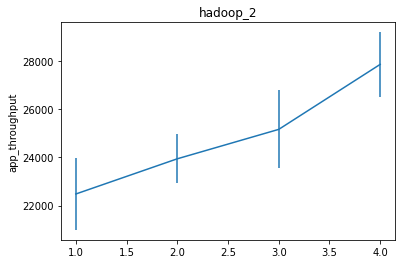

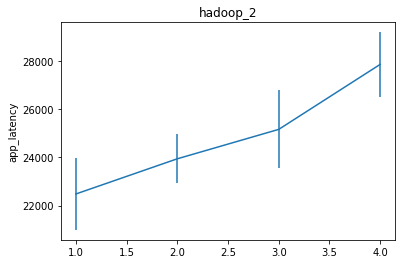

In [3]:
expid = "hadoop_2"
#TODO resilient to expid vs dir
Coef: [33.26514094 -2.22451136]

hadoop_1

Coef: [20864.85238095  1600.41714286]

hadoop_linpack_1

Coef: [18129.22555556  2332.67761905]

'\ndf = readDF(expid) \ndfs = splitDF(df)\nys, _ = getMetrics(dfs)\nxs = list(range(1, len(ys)+1))\nxs2 = [[i] for i in xs]\nreg = linear_model.LinearRegression()\nreg.fit(xs2, ys)\ncoef = np.array([reg.intercept_, reg.coef_[0]])\nprint(f"Reg coeff: {coef}")\n\n# Plot metric\n# Plot \n\nplot_regression_line(xs, ys, coef)\n# TODO wrap into function\n# TODO print cost function\n'


df = readDF(expid, "../results/all_limitless/baati") 
plotPerf(df, expid, "app_throughput")
plotPerf(df, expid, "app_latency")

In [53]:
dir(reg)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_decision_function',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_preprocess_data',
 '_residues',
 '_set_intercept',
 'coef_',
 'copy_X',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'n_jobs',
 'normalize',
 'predict',
 'rank_',
 'score',
 'set_params',
 'singular_']

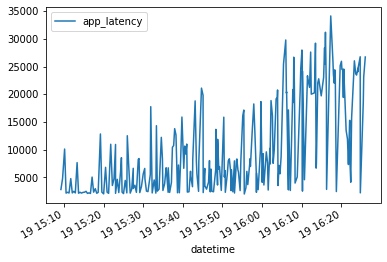

In [27]:
df.plot(x="datetime", y="app_latency")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ef35a2710>],
      dtype=object)

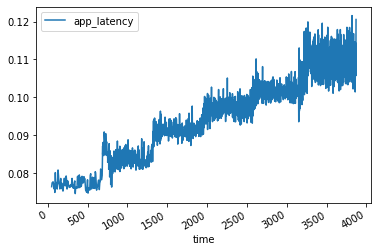

In [45]:
lat = df["app_latency"]
#lat.min()
#df.info()
df2 = df
for ai in df["ai_name"].unique():
    df2[f"latency_{ai}"] = df.loc[df["ai_name"] == ai, "app_latency"]
#df2.info()
df2.plot(x="time", y="app_latency", subplots=True)

In [46]:
cols = [f"latency_{ai}" for ai in df["ai_name"].unique()]
df3 = df2[["datetime"] + cols]

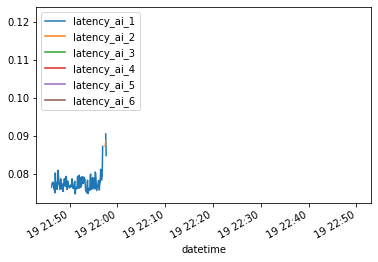

In [48]:
df3.plot(x="datetime")